# 1 Import bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2 Parâmetros de simulação e niveis de estoque
- Assumindo um conhecimento prévio sobre a distribuição da demanda (normal)

In [60]:
# Num simulações
num_simulacoes = 2

In [61]:
# Qtd de dias por simulação (6 meses)
n_dias = 180

In [62]:
media_demanda = 30  # Demanda diaria
desvio_padrao_demanda = 2 # Desv pad diario


In [63]:
## Niveis de estoque atual
estoque_inicial = 1500 

# 3 Regras de negócio

## 3.1 Lead time fornecedor
- Assumindo um conhecimento prévio sobre a distribuição do lead time do fornecedor
- Os fornecedores geralmente trabalham com tempo min, max e o mais provável
- Assumiremos distribuição triangula, portanto!

In [64]:
tempo_reposicao_min = 4 
tempo_reposicao_max = 14
tempo_reposicao_most_likely = 10

## 3.2 Estoque mínimo
- Estoque mínimo é aquele que quando atingido deve ser efetuado uma compra imediatamente!

- O estoque mínimo, como regra de negócio dessa empresa é definido como a quantidade a ser mantida no estoque para lidar com possíveis faltas desse produto no fornecedor
- Deve ser levado em considerado o lead time máximo do fornecedor, dess forma definiremos como a quantidade para suprir 2* o leadtime máximo do fornecedor.

In [65]:
estoque_minimo = media_demanda * (tempo_reposicao_max * 2)
estoque_minimo

840

## 3.3 A quantidade reabastecida (negociada no ato da compra)
- Política de abastecimento: Na data de chegada do pedido o estoque tem que ser suficiente para abastecer +2 meses + lead time fornecedor máximo antes de atingir o nível de estoque minimo novamente


In [66]:
n_dias_reabast = 60
qtd_comprada_dia = media_demanda * (n_dias_reabast + tempo_reposicao_max)
qtd_comprada_dia

2220

# 4 Simulação de Monte Carlo

## 4.1 Simulação 

In [100]:
# Resultado da simulação
df_resultados = pd.DataFrame(columns = ['n_simulacao', 'n_dia','estoque_dia','demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'qtd_comprada_dia','lead_time_forn_dia','dia_prox_reabastecimento', 'flag_houve_stockout'])

# Roda varias simulações
for n_sim in range(1, num_simulacoes+1):

    # Simula a demanda para os próximos n_dias (normal)
    demandas = np.random.normal(media_demanda, desvio_padrao_demanda, n_dias)
    demandas = demandas.astype(int)  # Convertendo para inteiros

    ## Inicializa o estoque para os niveis atuais no começo da simulação
    estoque = estoque_inicial

    ## Inicializa o dataframe de compras em aberto
    df_compras = pd.DataFrame(columns=['qtd','leadtime','n_dia','n_dia_chegada'])
    

    # Percorre cada dia de simulação
    for dia in range(n_dias):

        ## Iniciando o dia da simulação sem reabastecimento e sem compra ainda sem stockout
        flag_reabasteceu = 0
        flag_comprou = 0
        qtd_comprada_dia = np.nan
        tempo_reposicao_dia = np.nan
        n_dia_chegada = np.nan
        qtd_reabastecida = np.nan
        flag_houve_stockout = 0

        ########## Efetua Reposição de produtos no dia da simulação
        if dia in df_compras.n_dia_chegada.unique().tolist():

            df_a_reabastecer = df_compras[df_compras['n_dia_chegada']==dia]
            qtd_reabastecida = df_a_reabastecer.qtd.sum()

            ## Atualiza estoque reabastecido
            estoque = estoque + qtd_reabastecida

            ## Atualiza o dataframe de compras em aberto após reabastecimento
            df_compras = df_compras[df_compras['n_dia_chegada']!=dia]

            ## Atualiza flag reabastecimento
            flag_reabasteceu = 1

        # Reduz o estoque baseado na demanda
        estoque = estoque - demandas[dia]

        ## Corrige o estoque para 0 pois nao pode ser negativo
        if estoque < 0:
            estoque = 0
 

        ########## Verifica condição de stockout
        if estoque == 0:
            flag_houve_stockout = 1

        ########## Efetua compra no dia da simulação
        # Inicializa/reseta variavel de decisão de compra
        comprar = False
        qtd_comprada_dia = 0
        n_dia_chegada = np.nan
        qtd_comprada_historico = 0
        qtd_comprada_dia = 0
        tempo_reposicao_dia = 0

        
        # Caso estoque atinja o estoque mínimo inicializa checagens para decisão de compra
        if estoque < estoque_minimo:


            ## Caso ja tenha compras em aberto então checar outras condições (se a compra será suficiente por ex)
            if len(df_compras) > 0:

                ## Checa se o pedido de compra em aberto será suficiente para superar o estoque mínimo na data prevista da entrega
                ## Caso haja multiplas compras checa a qtd total comprada e o nível de estoque na data prevista de entrega mais distante
                qtd_comprada_historico = df_compras.qtd.sum()
                n_dia_chegada = df_compras.n_dia_chegada.max()
                estimativa_estoque_data_entrega_max = estoque - media_demanda * (n_dia_chegada - dia) + qtd_comprada_historico


                ## Caso as compras não tenham sido suficientes para superar o estoque mínimo então efetuar nova compra
                if estimativa_estoque_data_entrega_max < estoque_minimo:
                
                    comprar = True
                    flag_comprou = 1

                else:
                    comprar = False

            ## Caso nao tenha compras em aberto então é necessário comprar!!        
            else:
                comprar = True
                flag_comprou = 1



            ## Efetua a compra
            if comprar == True:
   
                # Simula o lead time com distribuição triangular
                tempo_reposicao_dia = np.random.triangular(
                    tempo_reposicao_min,
                    tempo_reposicao_most_likely,
                    tempo_reposicao_max)
                
                tempo_reposicao_dia = int(tempo_reposicao_dia) ## em dias inteiros

                n_dia_chegada = dia + tempo_reposicao_dia ## Calcula qtd de dias até a reposição
                
                
                # O pedido é efetuado:
                ## na data de chegada do pedido o estoque tem que ser suficiente para abastecer +2 meses antes de atingir o estoque minimo novamente
                ## qtd_comprada_dia
                qtd_comprada_dia = media_demanda * (n_dias_reabast + tempo_reposicao_max)

                ## Armazena os dados de compra
                df_compra_dia = pd.DataFrame(np.array([[qtd_comprada_dia,tempo_reposicao_dia,dia,n_dia_chegada ]]), columns=['qtd','leadtime','n_dia','n_dia_chegada'])
                df_compras = pd.concat([df_compras, df_compra_dia], ignore_index=True)
        

        # Armazena os resultados da simulação diaria por n_sim
        df_resultados_dia = pd.DataFrame(np.array([[n_sim, dia, estoque, demandas[dia], flag_reabasteceu, qtd_reabastecida, flag_comprou, qtd_comprada_dia, tempo_reposicao_dia, n_dia_chegada, flag_houve_stockout ]]), 
                                         columns = ['n_simulacao', 'n_dia','estoque_dia', 'demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'qtd_comprada_dia','lead_time_forn_dia','dia_prox_reabastecimento', 'flag_houve_stockout'])
        df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)


        ## Report Status    
        ##print(f'simulacao = {n_sim} - dia = {dia} - estoque = {estoque}')

C:\Users\pichau\AppData\Local\Temp\ipykernel_3960\4035581818.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)


In [38]:
## conta qts stockout teve e por qts dias vc ficou sem atender a demanda diaria e quanto isso representa em perdas...
## Problema: tenho que aumentar meu capital de giro reduzindo o estoque, comprar menos e aumentar a qtd de pedidos,
## até quanto eu consigo flexibilizar essa politica de compra sem causar stockouts 
## e caso haja stockout qual é o tradeoff da "capital de giro" vs qtd dinheiro perdido por stockout.

## 4.2 Avaliação dos resultados

In [101]:
df_resultados.head(40)

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout
0,1.0,0.0,1469.0,31.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
1,1.0,1.0,1442.0,27.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
2,1.0,2.0,1410.0,32.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
3,1.0,3.0,1379.0,31.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
4,1.0,4.0,1352.0,27.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
5,1.0,5.0,1321.0,31.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
6,1.0,6.0,1292.0,29.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
7,1.0,7.0,1258.0,34.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
8,1.0,8.0,1227.0,31.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
9,1.0,9.0,1198.0,29.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0


In [102]:
df_resultados[df_resultados['flag_houve_stockout']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout


In [103]:
df_resultados[df_resultados['flag_comprou']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout
21,1.0,21.0,834.0,30.0,0.0,NaN,1.0,2220.0,4.0,25.0,0.0
96,1.0,96.0,837.0,28.0,0.0,NaN,1.0,2220.0,6.0,102.0,0.0
172,1.0,172.0,816.0,30.0,0.0,NaN,1.0,2220.0,10.0,182.0,0.0
202,2.0,22.0,825.0,30.0,0.0,NaN,1.0,2220.0,9.0,31.0,0.0
278,2.0,98.0,819.0,30.0,0.0,NaN,1.0,2220.0,9.0,107.0,0.0
352,2.0,172.0,837.0,27.0,0.0,NaN,1.0,2220.0,9.0,181.0,0.0


In [104]:
df_resultados[df_resultados['flag_reabasteceu']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout
25,1.0,25.0,2931.0,33.0,1.0,2220.0,0.0,0.0,0.0,NaN,0.0
102,1.0,102.0,2886.0,29.0,1.0,2220.0,0.0,0.0,0.0,NaN,0.0
211,2.0,31.0,2777.0,29.0,1.0,2220.0,0.0,0.0,0.0,NaN,0.0
287,2.0,107.0,2777.0,29.0,1.0,2220.0,0.0,0.0,0.0,NaN,0.0


- Ambas simulações não houveram nenhum stockout ao longo de 180 dias, houveram 3 compras ao longo do período e 2 resposições de estoque!

## 4.3 Visualização simulações

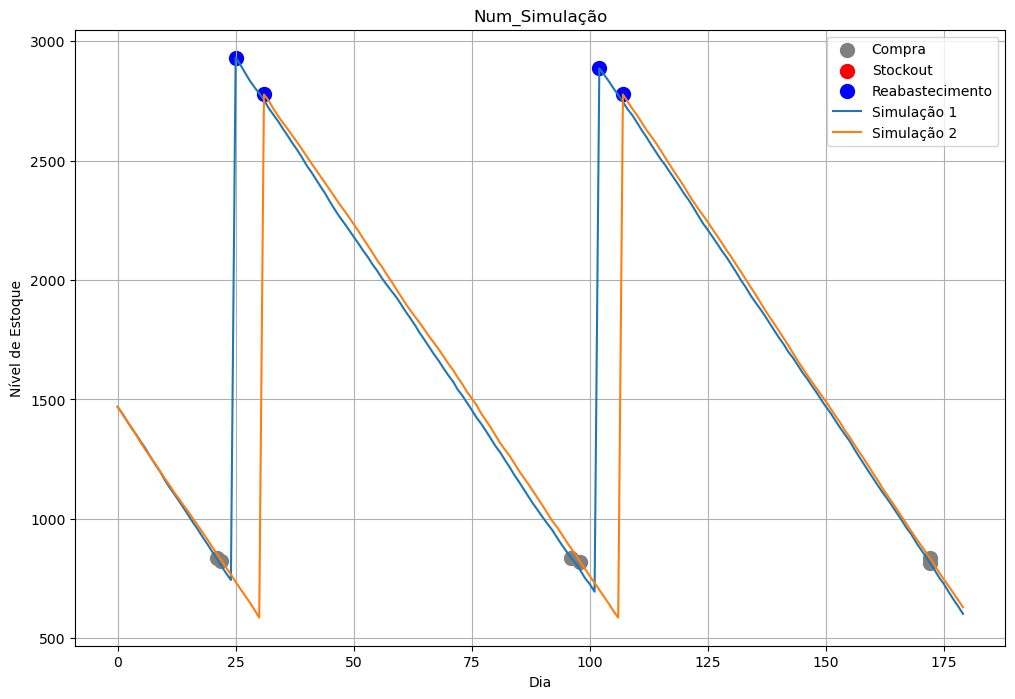

In [105]:
# Obter lista de simulações
lista_simulacoes = df_resultados['n_simulacao'].unique()

# Criar o gráfico de linha para cada simulação
plt.figure(figsize=(12, 8))


# Manter um controle para evitar duplicatas na legenda
compra_legenda_adicionada = False
reabastecimento_legenda_adicionada = False
stockout_legenda_adicionada = False


for simulacao in lista_simulacoes:
    df_simulacao = df_resultados[df_resultados['n_simulacao'] == simulacao]

    # pontos cinzas em dias de compras
    df_compras = df_simulacao[df_simulacao['flag_comprou'] == 1]
    if not compra_legenda_adicionada:
        # Só adicionar a legenda uma vez para compras
        plt.scatter(df_compras['n_dia'], df_compras['estoque_dia'], color='gray', s=100, marker='o', label='Compra')
        compra_legenda_adicionada = True
    else:
        plt.scatter(df_compras['n_dia'], df_compras['estoque_dia'], color='gray', s=100, marker='o')

    # pontos vermelhos em dias de stockouts
    df_stockout = df_simulacao[df_simulacao['flag_houve_stockout'] == 1]
    if not stockout_legenda_adicionada:
        # Só adicionar a legenda uma vez para stockouts
        plt.scatter(df_stockout['n_dia'], df_stockout['estoque_dia'], color='red', s=100, marker='o', label='Stockout')
        stockout_legenda_adicionada = True
    else:
        plt.scatter(df_stockout['n_dia'], df_stockout['estoque_dia'], color='red', s=100, marker='o')

    # pontos azuis em dias de reabastecimentos
    df_reabastecimento = df_simulacao[df_simulacao['flag_reabasteceu'] == 1]
    if not reabastecimento_legenda_adicionada:
        # Só adicionar a legenda uma vez para reabastecimento
        plt.scatter(df_reabastecimento['n_dia'], df_reabastecimento['estoque_dia'], color='blue', s=100, marker='o', label='Reabastecimento')
        reabastecimento_legenda_adicionada = True
    else:
        plt.scatter(df_reabastecimento['n_dia'], df_reabastecimento['estoque_dia'], color='blue', s=100, marker='o')


    # Gráfico de linha para o estoque diario
    #plt.plot(df_simulacao['n_dia'], df_simulacao['estoque_dia'])
    plt.plot(df_simulacao['n_dia'], df_simulacao['estoque_dia'], label=f'Simulação {int(simulacao)}')


    # Ao final de cada grafico de linha adicionar um identificador da simulação
    ultimo_dia = df_simulacao['n_dia'].iloc[-1]
    estoque_final = df_simulacao['estoque_dia'].iloc[-1]
    
    # Adiciona uma anotação com uma flecha para a última posição do gráfico de linha
    #plt.annotate(
        #f'Simulação = {int(simulacao)}',
        #xy=(ultimo_dia, estoque_final), 
        #xytext=(ultimo_dia + 5, estoque_final), 
        #arrowprops=dict(facecolor='black', arrowstyle='->')
    #)


# Adicionar a legenda
plt.legend(loc='best')

# Ajustes no grafico
plt.xlabel('Dia')
plt.ylabel('Nível de Estoque')
plt.title('Num_Simulação')
plt.grid(True)  
plt.show() 

# 5 Instanciando e consolidando funções de simulação

- vamos escrever uma f(x) = f(inputs) -> resultados

In [97]:
## conta qts stockout teve e por qts dias vc ficou sem atender a demanda diaria e quanto isso representa em perdas...
## Problema: tenho que aumentar meu capital de giro reduzindo o estoque, comprar menos e aumentar a qtd de pedidos,
## até quanto eu consigo flexibilizar essa politica de compra sem causar stockouts 
## e caso haja stockout qual é o tradeoff da "capital de giro" vs qtd dinheiro perdido por stockout.

In [154]:
def simulacao_estoque_montecarlo(num_simulacoes,
                         n_dias,
                         media_demanda,
                         desvio_padrao_demanda,
                         estoque_inicial,
                         tempo_reposicao_min,
                         tempo_reposicao_max,
                         tempo_reposicao_most_likely,
                         n_dias_reabast,
                         estoque_minimo):
    
    # Resultado da simulação
    df_resultados = pd.DataFrame(columns = ['n_simulacao', 'n_dia','estoque_dia','demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'qtd_comprada_dia','lead_time_forn_dia','dia_prox_reabastecimento', 'flag_houve_stockout'])

    # Roda varias simulações
    for n_sim in range(1, num_simulacoes+1):

        # Simula a demanda para os próximos n_dias (normal)
        demandas = np.random.normal(media_demanda, desvio_padrao_demanda, n_dias)
        demandas = demandas.astype(int)  # Convertendo para inteiros

        ## Inicializa o estoque para os niveis atuais no começo da simulação
        estoque = estoque_inicial

        ## Inicializa o dataframe de compras em aberto
        df_compras = pd.DataFrame(columns=['qtd','leadtime','n_dia','n_dia_chegada'])
        

        # Percorre cada dia de simulação
        for dia in range(n_dias):

            ## Iniciando o dia da simulação sem reabastecimento e sem compra ainda sem stockout
            flag_reabasteceu = 0
            flag_comprou = 0
            qtd_comprada_dia = np.nan
            tempo_reposicao_dia = np.nan
            n_dia_chegada = np.nan
            qtd_reabastecida = np.nan
            flag_houve_stockout = 0

            ########## Efetua Reposição de produtos no dia da simulação
            if dia in df_compras.n_dia_chegada.unique().tolist():

                df_a_reabastecer = df_compras[df_compras['n_dia_chegada']==dia]
                qtd_reabastecida = df_a_reabastecer.qtd.sum()

                ## Atualiza estoque reabastecido
                estoque = estoque + qtd_reabastecida

                ## Atualiza o dataframe de compras em aberto após reabastecimento
                df_compras = df_compras[df_compras['n_dia_chegada']!=dia]

                ## Atualiza flag reabastecimento
                flag_reabasteceu = 1

            # Reduz o estoque baseado na demanda
            estoque = estoque - demandas[dia]

            ## Corrige o estoque para 0 pois nao pode ser negativo
            if estoque < 0:
                estoque = 0
    

            ########## Verifica condição de stockout
            if estoque == 0:
                flag_houve_stockout = 1

            ########## Efetua compra no dia da simulação
            # Inicializa/reseta variavel de decisão de compra
            comprar = False
            qtd_comprada_dia = 0
            n_dia_chegada = np.nan
            qtd_comprada_historico = 0
            qtd_comprada_dia = 0
            tempo_reposicao_dia = 0

            
            # Caso estoque atinja o estoque mínimo inicializa checagens para decisão de compra
            if estoque < estoque_minimo:


                ## Caso ja tenha compras em aberto então checar outras condições (se a compra será suficiente por ex)
                if len(df_compras) > 0:

                    ## Checa se o pedido de compra em aberto será suficiente para superar o estoque mínimo na data prevista da entrega
                    ## Caso haja multiplas compras checa a qtd total comprada e o nível de estoque na data prevista de entrega mais distante
                    qtd_comprada_historico = df_compras.qtd.sum()
                    n_dia_chegada = df_compras.n_dia_chegada.max()
                    estimativa_estoque_data_entrega_max = estoque - media_demanda * (n_dia_chegada - dia) + qtd_comprada_historico


                    ## Caso as compras não tenham sido suficientes para superar o estoque mínimo então efetuar nova compra
                    if estimativa_estoque_data_entrega_max < estoque_minimo:
                    
                        comprar = True
                        flag_comprou = 1

                    else:
                        comprar = False

                ## Caso nao tenha compras em aberto então é necessário comprar!!        
                else:
                    comprar = True
                    flag_comprou = 1


                ## Efetua a compra
                if comprar == True:
    
                    # Simula o lead time com distribuição triangular
                    tempo_reposicao_dia = np.random.triangular(
                        tempo_reposicao_min,
                        tempo_reposicao_most_likely,
                        tempo_reposicao_max)
                    
                    tempo_reposicao_dia = int(tempo_reposicao_dia) ## em dias inteiros

                    n_dia_chegada = dia + tempo_reposicao_dia ## Calcula qtd de dias até a reposição
                    
                    
                    # O pedido é efetuado:
                    ## na data de chegada do pedido o estoque tem que ser suficiente para abastecer n dias
                    
                    qtd_comprada_dia = media_demanda * (n_dias_reabast)

                    ## Armazena os dados de compra
                    df_compra_dia = pd.DataFrame(np.array([[qtd_comprada_dia,tempo_reposicao_dia,dia,n_dia_chegada ]]), columns=['qtd','leadtime','n_dia','n_dia_chegada'])
                    df_compras = pd.concat([df_compras, df_compra_dia], ignore_index=True)
            

            # Armazena os resultados da simulação diaria por n_sim
            df_resultados_dia = pd.DataFrame(np.array([[n_sim, dia, estoque, demandas[dia], flag_reabasteceu, qtd_reabastecida, flag_comprou, qtd_comprada_dia, tempo_reposicao_dia, n_dia_chegada, flag_houve_stockout ]]), 
                                            columns = ['n_simulacao', 'n_dia','estoque_dia', 'demanda_dia', 'flag_reabasteceu', 'qtd_reabastecida_dia', 'flag_comprou', 'qtd_comprada_dia','lead_time_forn_dia','dia_prox_reabastecimento', 'flag_houve_stockout'])
            df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)


            ## Report Status    
            ##print(f'simulacao = {n_sim} - dia = {dia} - estoque = {estoque}')

    return df_resultados

In [116]:
def plot_simulacoes(df_resultados, id_sim):

    # Obter lista de simulações
    ##lista_simulacoes = df_resultados['n_simulacao'].unique()

    # Criar o gráfico de linha para cada simulação
    plt.figure(figsize=(12, 8))


    # Manter um controle para evitar duplicatas na legenda
    compra_legenda_adicionada = False
    reabastecimento_legenda_adicionada = False
    stockout_legenda_adicionada = False


    for simulacao in [id_sim]:
        df_simulacao = df_resultados[df_resultados['n_simulacao'] == simulacao]

        # pontos cinzas em dias de compras
        df_compras = df_simulacao[df_simulacao['flag_comprou'] == 1]
        if not compra_legenda_adicionada:
            # Só adicionar a legenda uma vez para compras
            plt.scatter(df_compras['n_dia'], df_compras['estoque_dia'], color='gray', s=100, marker='o', label='Compra')
            compra_legenda_adicionada = True
        else:
            plt.scatter(df_compras['n_dia'], df_compras['estoque_dia'], color='gray', s=100, marker='o')

        # pontos vermelhos em dias de stockouts
        df_stockout = df_simulacao[df_simulacao['flag_houve_stockout'] == 1]
        if not stockout_legenda_adicionada:
            # Só adicionar a legenda uma vez para stockouts
            plt.scatter(df_stockout['n_dia'], df_stockout['estoque_dia'], color='red', s=100, marker='o', label='Stockout')
            stockout_legenda_adicionada = True
        else:
            plt.scatter(df_stockout['n_dia'], df_stockout['estoque_dia'], color='red', s=100, marker='o')

        # pontos azuis em dias de reabastecimentos
        df_reabastecimento = df_simulacao[df_simulacao['flag_reabasteceu'] == 1]
        if not reabastecimento_legenda_adicionada:
            # Só adicionar a legenda uma vez para reabastecimento
            plt.scatter(df_reabastecimento['n_dia'], df_reabastecimento['estoque_dia'], color='blue', s=100, marker='o', label='Reabastecimento')
            reabastecimento_legenda_adicionada = True
        else:
            plt.scatter(df_reabastecimento['n_dia'], df_reabastecimento['estoque_dia'], color='blue', s=100, marker='o')


        # Gráfico de linha para o estoque diario
        #plt.plot(df_simulacao['n_dia'], df_simulacao['estoque_dia'])
        plt.plot(df_simulacao['n_dia'], df_simulacao['estoque_dia'], label=f'Simulação {int(simulacao)}')


        # Ao final de cada grafico de linha adicionar um identificador da simulação
        ultimo_dia = df_simulacao['n_dia'].iloc[-1]
        estoque_final = df_simulacao['estoque_dia'].iloc[-1]
        
        # Adiciona uma anotação com uma flecha para a última posição do gráfico de linha
        #plt.annotate(
            #f'Simulação = {int(simulacao)}',
            #xy=(ultimo_dia, estoque_final), 
            #xytext=(ultimo_dia + 5, estoque_final), 
            #arrowprops=dict(facecolor='black', arrowstyle='->')
        #)


    # Adicionar a legenda
    plt.legend(loc='best')

    # Ajustes no grafico
    plt.xlabel('Dia')
    plt.ylabel('Nível de Estoque')
    plt.title('Num_Simulação')
    plt.grid(True)  
    plt.show() 

In [160]:
n_dias_reabast ## Variaveis que posso mudar
estoque_minimo ## Variaveis que posso mudar

df_resultados = simulacao_estoque_montecarlo(num_simulacoes = 100,
                         n_dias = 180,
                         media_demanda = 2,
                         desvio_padrao_demanda = 0.5,
                         estoque_inicial = 25,
                         tempo_reposicao_min = 10,
                         tempo_reposicao_max = 30,
                         tempo_reposicao_most_likely = 20,
                         n_dias_reabast = 1,
                         estoque_minimo = 28)

df_resultados

C:\Users\pichau\AppData\Local\Temp\ipykernel_3960\4086053456.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, df_resultados_dia], ignore_index=True)


,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout
0,1.0,0.0,23.0,2.0,0.0,NaN,1.0,2.0,17.0,17.0,0.0
1,1.0,1.0,22.0,1.0,0.0,NaN,1.0,2.0,24.0,25.0,0.0
2,1.0,2.0,21.0,1.0,0.0,NaN,1.0,2.0,28.0,30.0,0.0
3,1.0,3.0,19.0,2.0,0.0,NaN,1.0,2.0,14.0,17.0,0.0
4,1.0,4.0,17.0,2.0,0.0,NaN,1.0,2.0,26.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17995,100.0,175.0,28.0,1.0,1.0,2.0,0.0,0.0,0.0,NaN,0.0
17996,100.0,176.0,28.0,2.0,1.0,2.0,0.0,0.0,0.0,NaN,0.0
17997,100.0,177.0,28.0,2.0,1.0,2.0,0.0,0.0,0.0,NaN,0.0
17998,100.0,178.0,28.0,2.0,1.0,2.0,0.0,0.0,0.0,NaN,0.0


In [161]:
df_resultados[df_resultados['flag_comprou']==1]

,n_simulacao,n_dia,estoque_dia,demanda_dia,flag_reabasteceu,qtd_reabastecida_dia,flag_comprou,qtd_comprada_dia,lead_time_forn_dia,dia_prox_reabastecimento,flag_houve_stockout
0,1.0,0.0,23.0,2.0,0.0,NaN,1.0,2.0,17.0,17.0,0.0
1,1.0,1.0,22.0,1.0,0.0,NaN,1.0,2.0,24.0,25.0,0.0
2,1.0,2.0,21.0,1.0,0.0,NaN,1.0,2.0,28.0,30.0,0.0
3,1.0,3.0,19.0,2.0,0.0,NaN,1.0,2.0,14.0,17.0,0.0
4,1.0,4.0,17.0,2.0,0.0,NaN,1.0,2.0,26.0,30.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17990,100.0,170.0,22.0,1.0,0.0,NaN,1.0,2.0,27.0,197.0,0.0
17991,100.0,171.0,22.0,2.0,1.0,2.0,1.0,2.0,15.0,186.0,0.0
17992,100.0,172.0,23.0,1.0,1.0,2.0,1.0,2.0,29.0,201.0,0.0
17994,100.0,174.0,27.0,1.0,0.0,NaN,1.0,2.0,14.0,188.0,0.0


In [162]:
n_simulacoes_distintas_com_stockouts = df_resultados[df_resultados['flag_houve_stockout']==1].n_simulacao.nunique()
n_simulacoes_distintas_com_stockouts

96

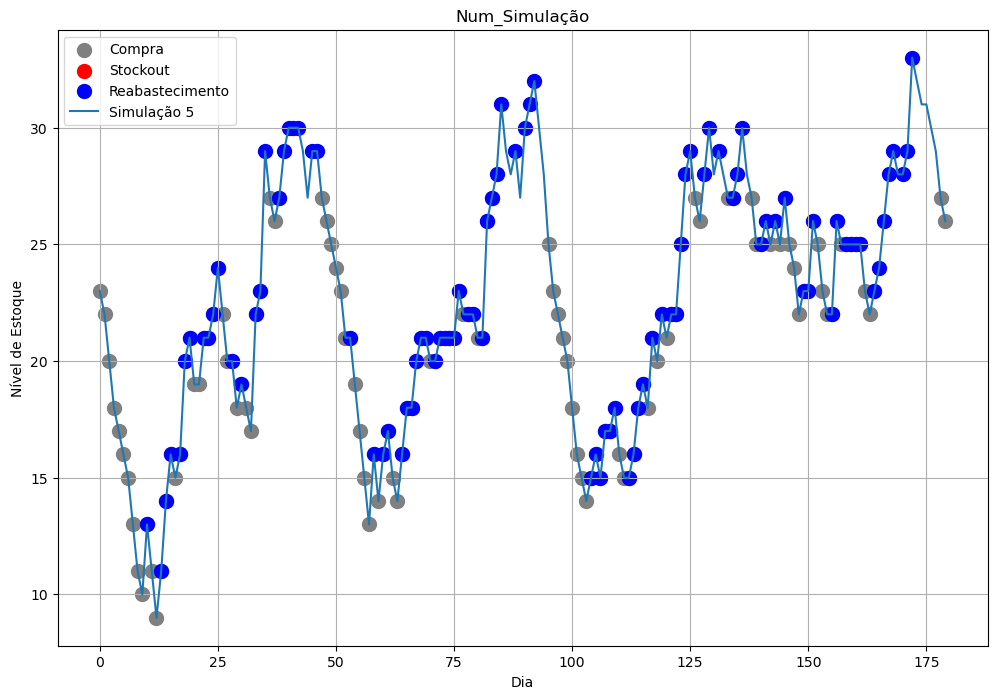

In [159]:
plot_simulacoes(df_resultados, id_sim = 5)

Probabilidade de Stockout: 1.0
Estoque Médio ao Final do Período: -128.644
Desvio Padrão do Estoque ao Final do Período: 88.81898031389463


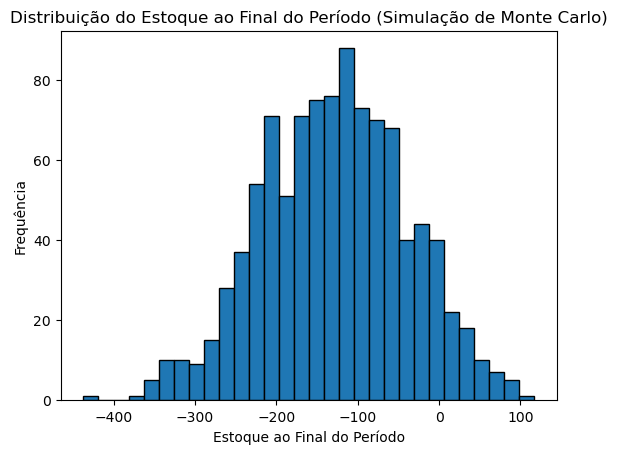

In [7]:
# Análise dos resultados
probabilidade_stockout = sum(resultados_stockout) / num_simulacoes
media_estoque_final = np.mean(resultados_estoque_final)
desvio_padrao_estoque_final = np.std(resultados_estoque_final)

# Exibir resultados
print("Probabilidade de Stockout:", probabilidade_stockout)
print("Estoque Médio ao Final do Período:", media_estoque_final)
print("Desvio Padrão do Estoque ao Final do Período:", desvio_padrao_estoque_final)

# Visualizar a distribuição do estoque final
plt.hist(resultados_estoque_final, bins=30, edgecolor='black')
plt.xlabel("Estoque ao Final do Período")
plt.ylabel("Frequência")
plt.title("Distribuição do Estoque ao Final do Período (Simulação de Monte Carlo)")
plt.show()

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Número de simulações
num_simulacoes = 1000

# Parâmetros da simulação
media_demanda = 100  # Demanda média diária
desvio_padrao_demanda = 20  # Desvio padrão da demanda
estoque_inicial = 300  # Estoque inicial
estoque_minimo = 50  # Limite mínimo para reabastecimento
quantidade_reabastecimento = 200  # Quantidade a ser reabastecida
tempo_reposicao_min = 2 

Probabilidade de Stockout: 1.0
Estoque Médio ao Final do Período: -131.678
Desvio Padrão do Estoque ao Final do Período: 93.17622183797752


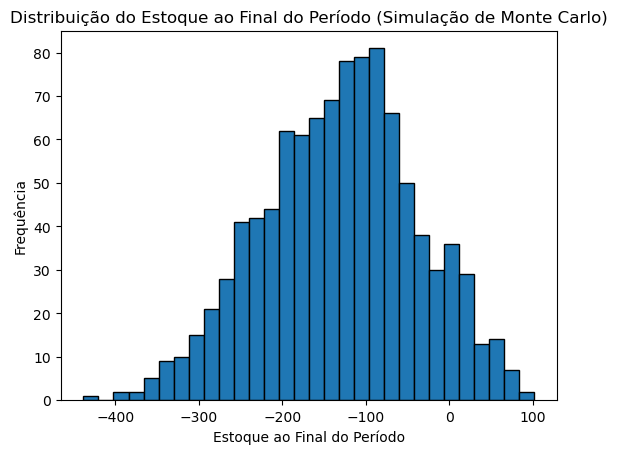

In [71]:
# Tempo mínimo para reposição
tempo_reposicao_max = 5  # Tempo máximo para reposição
tempo_reposicao_most_likely = 3  # Tempo mais provável para reposição

# Resultado da simulação
resultados_stockout = []  # Quantidade de vezes que houve stockout
resultados_estoque_final = []  # Estoque ao final do período de simulação

# Simulação de Monte Carlo
for i in range(num_simulacoes):
    # Simular a demanda para 30 dias
    demandas = np.random.normal(media_demanda, desvio_padrao_demanda, 30)
    demandas = demandas.astype(int)  # Convertendo para inteiros
    estoque = estoque_inicial
    houve_stockout = False
    
    # Simular o processo de gerenciamento de estoques
    for dia in range(30):
        # Reduzir o estoque com base na demanda diária
        estoque -= demandas[dia]
        
        # Verificar se houve stockout
        if estoque < 0:
            houve_stockout = True
        
        # Se o estoque cair abaixo do mínimo, iniciar o processo de reposição
        if estoque < estoque_minimo:
            # Tempo de reposição com distribuição triangular
            tempo_reposicao = np.random.triangular(
                tempo_reposicao_min,
                tempo_reposicao_most_likely,
                tempo_reposicao_max,
            )
            # Reabastecer após o tempo de reposição
            if dia + tempo_reposicao < 30:
                estoque += quantidade_reabastecimento
        
    # Armazenar os resultados
    resultados_stockout.append(houve_stockout)
    resultados_estoque_final.append(estoque)

# Análise dos resultados
probabilidade_stockout = sum(resultados_stockout) / num_simulacoes
media_estoque_final = np.mean(resultados_estoque_final)
desvio_padrao_estoque_final = np.std(resultados_estoque_final)

# Exibir resultados
print("Probabilidade de Stockout:", probabilidade_stockout)
print("Estoque Médio ao Final do Período:", media_estoque_final)
print("Desvio Padrão do Estoque ao Final do Período:", desvio_padrao_estoque_final)

# Visualizar a distribuição do estoque final
plt.hist(resultados_estoque_final, bins=30, edgecolor='black')
plt.xlabel("Estoque ao Final do Período")
plt.ylabel("Frequência")
plt.title("Distribuição do Estoque ao Final do Período (Simulação de Monte Carlo)")
plt.show()

In [27]:
!pip install simpy

In [73]:
len(resultados_estoque_final)

1000